In [1]:
import geemap
from geemap import colormaps
from geemap import foliumap
import ee
import sys
sys.path.append('C:/Users/wb514197/Repos/GEE_Zonal/src')
from gee_tools import Catalog, ZonalStats
from gee_helpers import get_zonal_res
import pandas as pd
import os
import glob
import seaborn as sns
from datetime import datetime
# from dotenv import load_dotenv, find_dotenv
# import datapane as dp
from matplotlib import pyplot as plt
from geemap.conversion import *
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf

eemont not available
Google Drive tools are not available


In [2]:
ee.Initialize()

In [3]:
pac_dir = 'X:/data/pacific'
png_dir = os.path.join(pac_dir, "PNG")
min_dir = os.path.join(png_dir, 'mining')

In [4]:
mines = gpd.read_file(os.path.join(min_dir, "mines_wgs.shp")).assign(source="Google Maps KML")
mindat = gpd.read_file(os.path.join(min_dir, "mindat_mines.shp")).assign(source="Mindat Database").rename(columns={'name':'Name'})
mines_mask = gpd.read_file(os.path.join(min_dir, "mask_admin.shp")).assign(source="Digitized").rename(columns={'Latitude':'lat', 'Longitude':'lon', 'Id':'ID'})

In [5]:
mines = mines.loc[mines.confirmed==1].copy()

In [6]:
gas = mines_mask.loc[mines_mask.gas==1].copy()

In [7]:
sites = pd.concat([mines, gas])
sites.reset_index(inplace=True, drop=True)

In [8]:
sites = sites.to_crs("EPSG:3832")
sites.loc[:, "geometry"] = sites.buffer(4000)
sites = sites.to_crs("EPSG:4326")
sites.reset_index(inplace=True)

In [9]:
aoi = geopandas_to_ee(sites)

In [10]:
def smoothenViirs(collection, window_size):

    def prepareImage(img):
        rad = img.select('avg_rad')
        cf_cvg = img.select('cf_cvg') #.rename('avg_rad')
        cf_eq0 = cf_cvg.gt(0)
        img_masked = rad.mask(cf_eq0)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smooter function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [11]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")

In [12]:
viirs_interpolated = smoothenViirs(viirs, 3)

In [13]:
def prepareImage(img):
    img = img.clip(aoi)
    rad = img.select('avg_rad')
    cf_cvg = img.select('cf_cvg') #.rename('avg_rad')
    cf_eq0 = cf_cvg.gt(0)
    img_masked = rad.mask(cf_eq0)
    
    return img_masked

In [14]:
viirs_masked = viirs.map(prepareImage)

In [15]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    output_name = '',
    scale = 500,
    frequency = 'annual',
    temporal_stat = 'mean',
    output_dir = '',
    ee_dataset = viirs_masked
)
res = zs.runZonalStats()
res = res.getInfo()

In [16]:
df_ntl = get_zonal_res(res)

In [17]:
def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        new_name = "rad"+"__"+p[0]
        return(new_name)
    else:
        return col
df_ntl.rename(rename_func, axis=1, inplace=True)

In [18]:
df_ntl_re = pd.wide_to_long(
    df_ntl,
    stubnames = ['rad'],
    i = 'index',
    j = 'year',
    sep = "__"
)
df_ntl_re.reset_index(inplace=True)
# df_ntl_re.loc[:,"date"] = pd.to_datetime(df_ntl_re.date, format="%Y%m%d")

In [19]:
df_ntl_re.loc[df_ntl_re.gas.isna(), "gas"] = 0

In [20]:
df_sum = df_ntl_re[['rad','gas', 'year']].groupby(['gas', 'year']).sum()

In [21]:
df_sum.reset_index(inplace=True)

In [22]:
df_sum.head()

,gas,year,rad
0,0.0,2014,2514.914482
1,0.0,2015,2782.902716
2,0.0,2016,2529.367279
3,0.0,2017,3481.975024
4,0.0,2018,3434.919131


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Sum of Lights'),
 Text(0.5, 1.0, 'Sum of Lights Trend')]

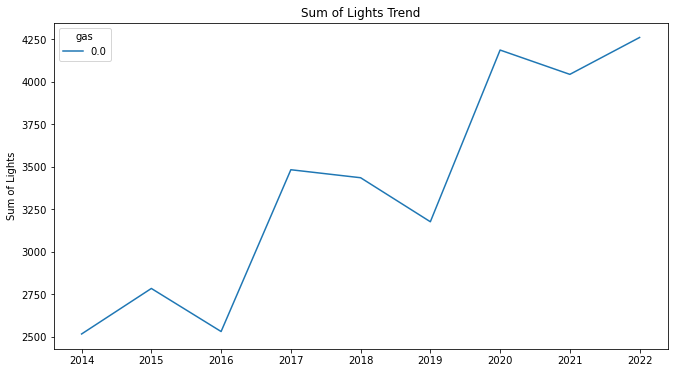

In [23]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_sum.loc[df_sum.gas==0], x="year", y="rad", 
                  hue="gas") #style="index", style_order=['interpolated', 'raw'] dashes=[(3, 3)])
ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend")

In [25]:
# ax.lines[0].set_linestyle("dotted")
# plt.legend(title='', loc='upper right', labels=['Raw Data', 'Interpolated'])
# plt.savefig("../docs/images/LAE.png", facecolor='white', dpi=300)

Nat accounts

In [9]:
nat_df = pd.read_excel("../data/png_nat_accounts.xlsx", 0)

In [10]:
sel = ['MINING AND QUARRYING', 'Extraction of crude petroleum and natural gas', 'Other Mining']
nat_df = nat_df.loc[nat_df.series.isin(sel)].copy()

In [11]:
nat_df_re = pd.melt(nat_df, id_vars="series", var_name="year", value_name='output')

In [12]:
nat_df_re.loc[:, 'year'] = nat_df_re.loc[:, 'year'].astype('int')

In [13]:
output_current = nat_df_re.copy()
# gva_current = nat_df_re.copy()
# gva_constant = nat_df_re.copy()

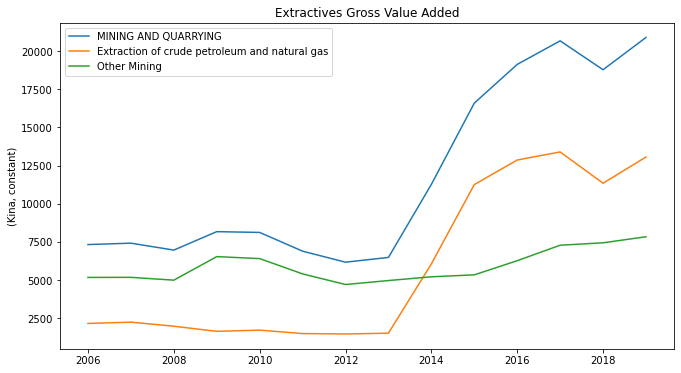

In [218]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=gva_constant, x="year", y="output", hue="series")
ax.set(xlabel="", ylabel="(Kina, constant)", title="Extractives Gross Value Added")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']

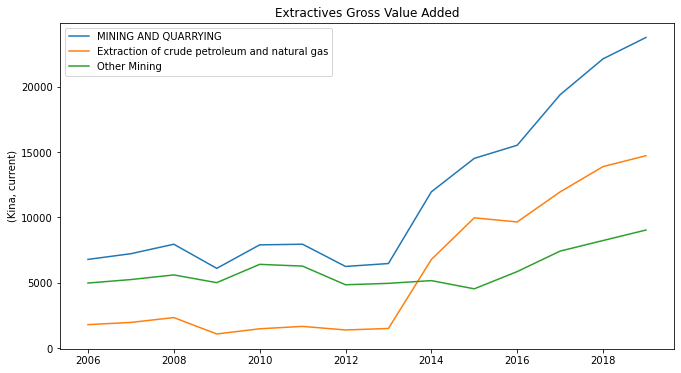

In [219]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=gva_current, x="year", y="output", hue="series")
ax.set(xlabel="", ylabel="(Kina, current)", title="Extractives Gross Value Added")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']

In [491]:
sns.set(font_scale = 1.5) # sns.set_style("white")

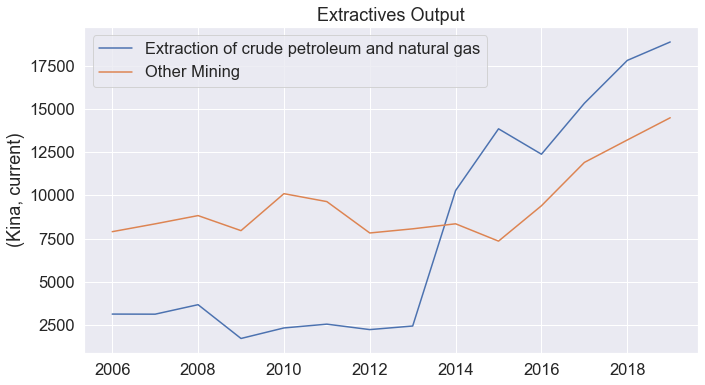

In [492]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=output_current.loc[output_current.series!="MINING AND QUARRYING"], x="year", y="output", hue="series")
ax.set(xlabel="", ylabel="(Kina, current)", title="Extractives Output")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']
plt.savefig("../docs/images/Output_Mining_Gas.png", facecolor='white', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=output_current.loc, x="year", y="output", hue="series")
ax.set(xlabel="", ylabel="(Kina, current)", title="Extractives Output")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']

In [225]:
mining = nat_df_re.loc[output_current.series=='Other Mining'].copy() # MINING AND QUARRYING
mining.loc[:, 'output_log'] = mining.output.transform('log')
mining.loc[:, 'output_pct_ch'] = mining.output.pct_change()
mining.loc[:, 'output_log_dif'] = mining.output_log.diff()
# mining = mining.loc[mining.year>=2014].copy()

In [224]:
mining

,series,year,output,output_log,output_pct_ch,output_log_dif
2,Other Mining,2006,7902.471055,8.974931,NaN,NaN
5,Other Mining,2007,8355.021368,9.030618,0.057267,0.055687
8,Other Mining,2008,8832.280770,9.086169,0.057122,0.055551
11,Other Mining,2009,7962.864918,8.982544,-0.098436,-0.103624
14,Other Mining,2010,10100.098150,9.220300,0.268400,0.237756
17,Other Mining,2011,9641.467397,9.173829,-0.045409,-0.046472
20,Other Mining,2012,7827.442071,8.965391,-0.188148,-0.208438
23,Other Mining,2013,8067.507609,8.995600,0.030670,0.030209
26,Other Mining,2014,8357.838029,9.030955,0.035988,0.035355
29,Other Mining,2015,7355.999479,8.903272,-0.119868,-0.127684


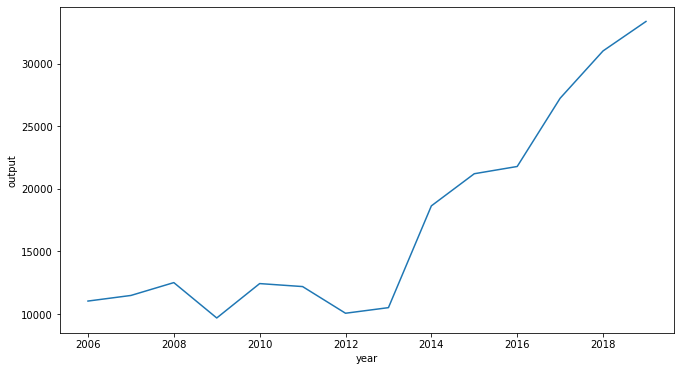

In [147]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=mining, x="year", y="output")
# ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend")

Harmz

In [14]:
from glob import glob
import rasterio as rio
from rasterstats import zonal_stats
from affine import Affine
from rasterio import features

In [15]:
ntl_dir = 'P:/Data/GLOBAL/NighttimeLights'
harm_dir = os.path.join(ntl_dir, 'LI_HARMONIZED')
files = glob(harm_dir+"/Harmonized*.tif")
files.sort()

In [16]:
pac_path = r'C:\Users\wb514197\WBG\EEAPV Pacific Observatory Files - Geospatial and Big Data\Data\Admin Boundaries'
pac_adm0 = gpd.read_file(os.path.join(pac_path, "Adm0_Pacific.shp"))
png = pac_adm0.loc[pac_adm0.ISO3=="PNG"].copy()
png = png.to_crs('EPSG:4326')
geom = png.geometry.iloc[0]

In [17]:
res = sites.copy()

In [18]:
files

['P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1992_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1993_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1994_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1995_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1996_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1997_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1998_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_1999_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_2000_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_2001_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmonized_DN_NTL_2002_calDMSP.tif',
 'P:/Data/GLOBAL/NighttimeLights\\LI_HARMONIZED\\Harmo

In [19]:
for file in files[14:]:
    year = file.split("_")[-2]
    src = rio.open(file)
    
    window = features.geometry_window(src, [geom])
    ul_y = window.col_off
    lr_x = window.row_off
    t = src.transform
    shifted_affine = Affine(t.a, t.b, t.c+ul_y*t.a, t.d, t.e, t.f+lr_x*t.e)
    
    data = src.read(1, window=window)    
    zs = pd.DataFrame(zonal_stats(sites, data, affine=shifted_affine, stats='sum', nodata=-1.5)).rename(columns = {'sum': f'{year}'})
    res = res.join(zs)
    print(f"done with {year}")

done with 2006
done with 2007
done with 2008
done with 2009
done with 2010
done with 2011
done with 2012
done with 2013
done with 2014
done with 2015
done with 2016
done with 2017
done with 2018


In [20]:
res.drop(columns=['geometry', 'PopupInfo'], inplace=True)

In [21]:
res.columns[15:]

Index(['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018'],
      dtype='object')

In [22]:
res.head(2)

,index,Name,SymbolID,confirmed,source,ID,lat,lon,ADM3_EN,ADM3_PCODE,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,Tolukuma Mine,0.0,1.0,Google Maps KML,NaN,NaN,NaN,NaN,NaN,...,20.0,57.0,20.0,65.0,46.0,383.0,381.0,376.0,375.0,356.0
1,1,Porgera Mine,0.0,1.0,Google Maps KML,NaN,NaN,NaN,NaN,NaN,...,1190.0,1282.0,1148.0,1370.0,1302.0,1955.0,2229.0,2135.0,2469.0,2577.0


In [23]:
res_re = pd.melt(res, id_vars=res.columns[0:15], value_vars=res.columns[15:], var_name="year", value_name='rad')

In [24]:
res_re.loc[:, 'year'] = res_re.loc[:, 'year'].astype('int')

In [25]:
res_re.loc[res_re.gas.isna(), "gas"] = 0

In [26]:
df_harm = res_re[['rad','gas', 'year']].groupby(['gas', 'year']).sum()

In [27]:
df_harm.reset_index(inplace=True)

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Sum of Lights'),
 Text(0.5, 1.0, 'Sum of Lights Trend')]

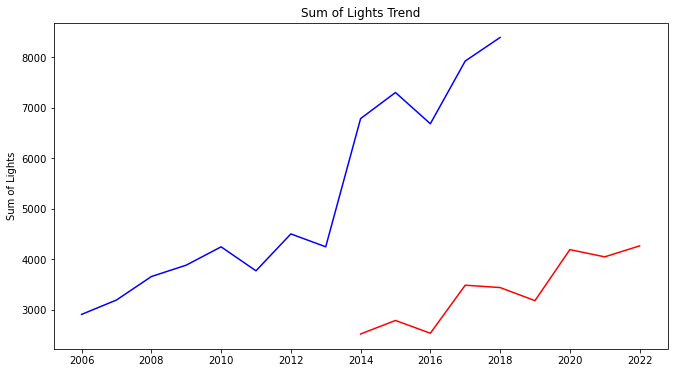

In [56]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_sum.loc[df_sum.gas==0], x="year", y="rad", 
                  color='red')
ax = sns.lineplot(data=df_harm.loc[df_harm.gas==0], x="year", y="rad", 
                  color="blue")
ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend")

In [28]:
df_harm.loc[:, "rad_log"] = df_harm.rad.transform('log')
# np.log10(df_harm['rad'])

In [29]:
both_ntl = df_harm[['year', 'rad']].groupby('year').sum().reset_index()
both_ntl.loc[:, "rad_log"] = both_ntl.rad.transform('log')

In [30]:
gas_ntl = df_harm.loc[df_harm.gas==1].copy()
min_ntl = df_harm.loc[df_harm.gas==0].copy()

In [463]:
gas_ntl = df_ntl_gas.copy().rename(columns={'rad_cal':'rad'})
min_ntl = df_ntl_mining.copy().rename(columns={'rad_cal':'rad'})

In [467]:
both_ntl = pd.concat([gas_ntl, min_ntl])
both_ntl = both_ntl[['year', 'rad']].groupby('year').sum().reset_index()

In [31]:
gas_ntl.loc[:, "rad_log"] = gas_ntl.rad.transform('log')
min_ntl.loc[:, "rad_log"] = min_ntl.rad.transform('log')
both_ntl.loc[:, "rad_log"] = both_ntl.rad.transform('log')

In [32]:
gas_ntl.loc[:, 'rad_pct_ch'] = gas_ntl.rad.pct_change()
min_ntl.loc[:, 'rad_pct_ch'] = min_ntl.rad.pct_change()
both_ntl.loc[:, 'rad_pct_ch'] = both_ntl.rad.pct_change()

gas_ntl.loc[:, 'rad_log_dif'] = gas_ntl.rad_log.diff()
min_ntl.loc[:, 'rad_log_dif'] = min_ntl.rad_log.diff()
both_ntl.loc[:, 'rad_log_dif'] = both_ntl.rad_log.diff()

In [482]:
sns.set()

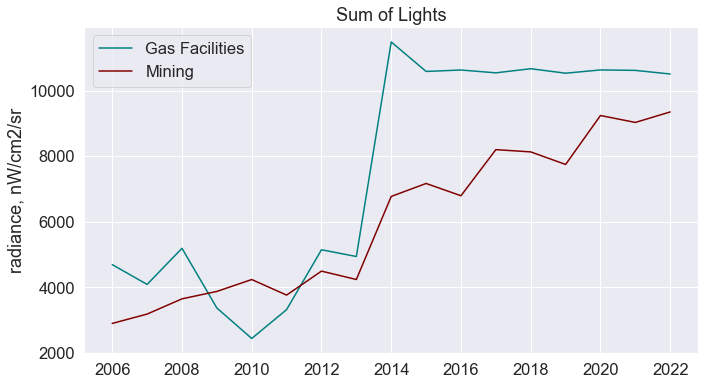

In [493]:
fig, ax = plt.subplots(figsize=(11, 6))
# ax = sns.lineplot(data=both_ntl, x="year", y="rad", 
#                   color='red')
ax = sns.lineplot(data=gas_ntl, x="year", y="rad", 
                  color='teal', label='Gas Facilities')
ax = sns.lineplot(data=min_ntl, x="year", y="rad", 
                  color="maroon", label='Mining')
ax.set(xlabel="", ylabel="radiance, nW/cm2/sr", title="Sum of Lights")
plt.savefig("../docs/images/Lights_Mining_Gas.png", facecolor='white', dpi=300)

In [35]:
# gva_constant, gva_current, output_current
nat_df_re = output_current.copy()

extractives = nat_df_re.loc[nat_df_re.series=='MINING AND QUARRYING'].copy() 
extractives.loc[:, 'output_log'] = extractives.output.transform('log')
extractives.loc[:, 'output_pct_ch'] = extractives.output.pct_change()
extractives.loc[:, 'output_log_dif'] = extractives.output_log.diff()

mining = nat_df_re.loc[nat_df_re.series=='Other Mining'].copy() 
mining.loc[:, 'output_log'] = mining.output.transform('log')
mining.loc[:, 'output_pct_ch'] = mining.output.pct_change()
mining.loc[:, 'output_log_dif'] = mining.output_log.diff()

gas = nat_df_re.loc[nat_df_re.series=='Extraction of crude petroleum and natural gas'].copy() 
gas.loc[:, 'output_log'] = gas.output.transform('log')
gas.loc[:, 'output_pct_ch'] = gas.output.pct_change()
gas.loc[:, 'output_log_dif'] = gas.output_log.diff()

In [511]:
# fig, ax = plt.subplots(figsize=(11, 6))
# ax = sns.lineplot(data=both_ntl, x="year", y="rad_log_dif", 
#                   color='red')
# ax = sns.lineplot(data=extractives, x="year", y="output_log_dif", 
#                   color="blue")

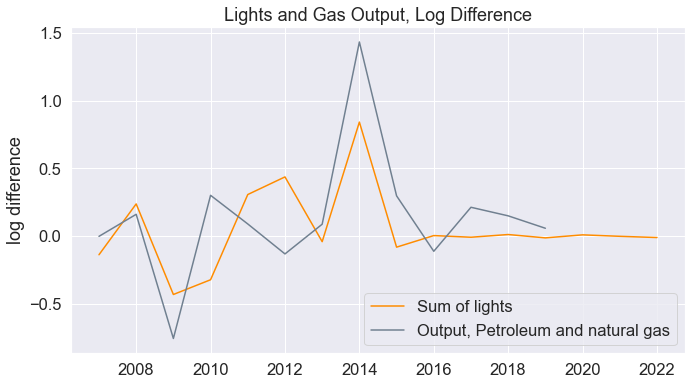

In [524]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=gas_ntl, x="year", y="rad_log_dif", 
                  color='darkorange', label="Sum of lights")
ax = sns.lineplot(data=gas, x="year", y="output_log_dif", 
                  color="slategray", label="Output, Petroleum and natural gas")
ax.set(xlabel="", ylabel="log difference", title="Lights and Gas Output, Log Difference")
plt.savefig("../docs/images/Lights_Gas_LogDiff.png", facecolor='white', dpi=300)

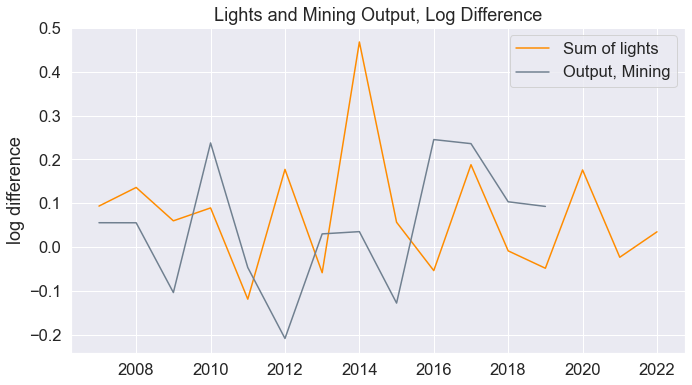

In [523]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=min_ntl, x="year", y="rad_log_dif", 
                  color='darkorange', label="Sum of lights")
ax = sns.lineplot(data=mining, x="year", y="output_log_dif", 
                  color="slategray", label="Output, Mining")
ax.set(xlabel="", ylabel="log difference", title="Lights and Mining Output, Log Difference")
plt.savefig("../docs/images/Lights_Mining_LogDiff.png", facecolor='white', dpi=300)

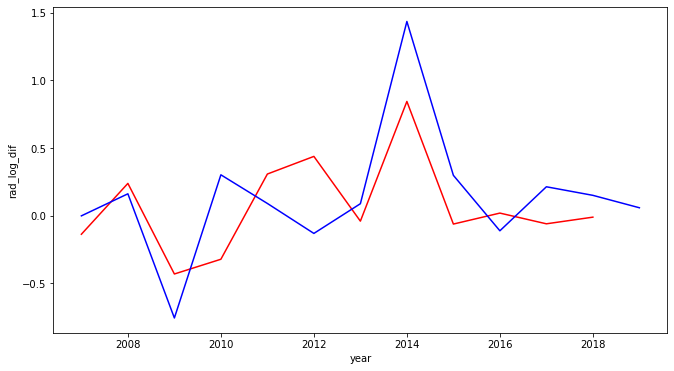

In [264]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=gas_ntl, x="year", y="rad_log_dif", 
                  color='red')
ax = sns.lineplot(data=gas, x="year", y="output_log_dif", 
                  color="blue")

In [43]:
df = mining.merge(min_ntl, on='year')

In [44]:
df.dropna(inplace=True)

In [45]:
mod = smf.ols(formula='output_log_dif ~ rad_log_dif', data=df)

In [46]:
res_mod = mod.fit()

In [47]:
print(res_mod.summary())

                            OLS Regression Results                            
Dep. Variable:         output_log_dif   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.094
Method:                 Least Squares   F-statistic:                   0.05839
Date:                Sat, 13 Aug 2022   Prob (F-statistic):              0.814
Time:                        09:25:58   Log-Likelihood:                 6.4233
No. Observations:                  12   AIC:                            -8.847
Df Residuals:                      10   BIC:                            -7.877
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0493      0.052      0.943      

C:\WBG\Anaconda\envs\ee\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [293]:
print(res_mod.summary())

                            OLS Regression Results                            
Dep. Variable:         output_log_dif   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     8.907
Date:                Fri, 12 Aug 2022   Prob (F-statistic):             0.0137
Time:                        15:42:08   Log-Likelihood:                -4.2578
No. Observations:                  12   AIC:                             12.52
Df Residuals:                      10   BIC:                             13.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0809      0.111      0.728      

C:\WBG\Anaconda\envs\ee\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Mining Lights and Combined Output

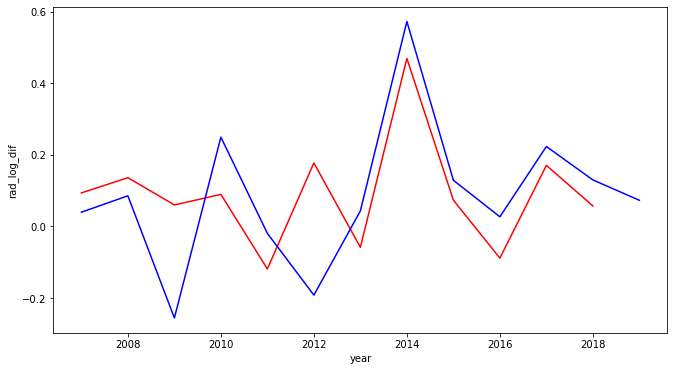

In [141]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=min_ntl, x="year", y="rad_log_dif", 
                  color='red')
ax = sns.lineplot(data=mining, x="year", y="output_log_dif", 
                  color="blue")
# ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend")

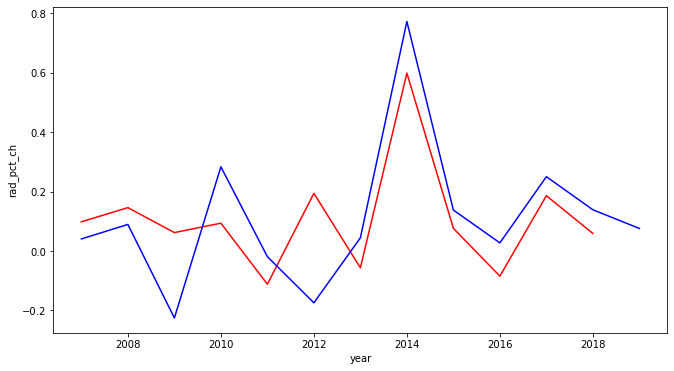

In [142]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=min_ntl, x="year", y="rad_pct_ch", 
                  color='red')
ax = sns.lineplot(data=mining, x="year", y="output_pct_ch", 
                  color="blue")

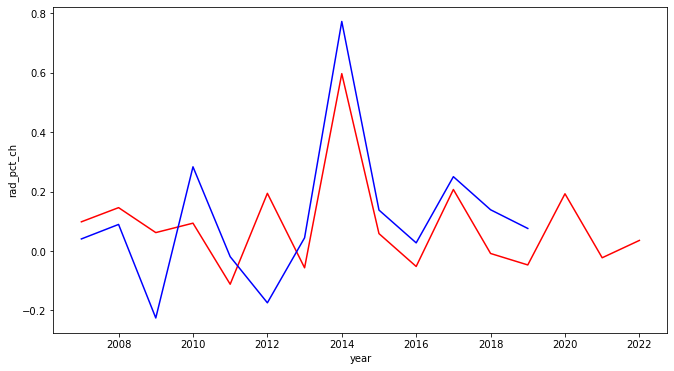

In [96]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_final.loc[df_final.gas==0], x="year", y="rad_pct_ch", 
                  color='red')
ax = sns.lineplot(data=mining, x="year", y="output_pct_ch", 
                  color="blue")
# ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend")

In [436]:
df_merge = df_sum.merge(df_harm, on=['year', 'gas'], suffixes=['_raw', '_cal'], how='outer')

In [437]:
df_merge = df_merge.loc[df_merge.gas==0]

In [438]:
df_merge = df_merge.sort_values('year')

In [439]:
data = df_merge.dropna()

In [440]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

In [441]:
Y = data.loc[:, "rad_cal"].values.reshape(-1, 1) 
X = data.loc[:, "rad_raw"].values.reshape(-1, 1) 
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [442]:
X_to_pred = df_merge.loc[:, 'rad_raw'].dropna().values.reshape(-1, 1)

In [443]:
Y_pred = linear_regressor.predict(X_to_pred)

In [444]:
df_merge.loc[:, 'rad_pred'] = np.nan

In [445]:
df_merge.loc[df_merge.year>2013, 'rad_pred'] = Y_pred.ravel()

In [446]:
df_merge.head(2)

,gas,year,rad_raw,rad_cal,rad_log,rad_pred
18,0.0,2006,NaN,2903.0,7.973500,NaN
19,0.0,2007,NaN,3188.0,8.067149,NaN


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Sum of Lights'),
 Text(0.5, 1.0, 'Sum of Lights Trend')]

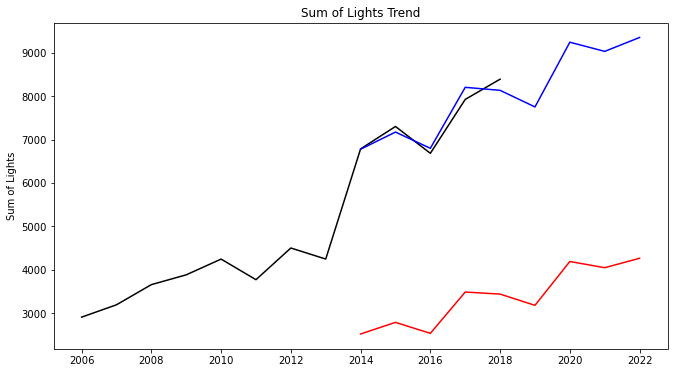

In [447]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_merge, x="year", y="rad_cal", 
                  color='black')
ax = sns.lineplot(data=df_merge, x="year", y="rad_raw", 
                  color='red')
ax = sns.lineplot(data=df_merge, x="year", y="rad_pred", 
                  color="blue")
ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend")

In [448]:
df_merge.loc[df_merge.year>2013, 'rad_cal'] = Y_pred.ravel()

In [434]:
df_ntl_gas = df_merge.drop(columns=['rad_raw', 'rad_pred', 'rad_log']).copy()

In [449]:
df_ntl_mining = df_merge.drop(columns=['rad_raw', 'rad_pred', 'rad_log']).copy()

In [435]:
df_ntl_gas.head(1)

,gas,year,rad_cal
26,1.0,2006,4697.0


In [450]:
df_ntl_mining.head(1)

,gas,year,rad_cal
18,0.0,2006,2903.0
